## Literature

https://quantpy.com.au/stochastic-calculus/brownian-motion-for-financial-mathematics/


https://www.youtube.com/watch?v=sIKD1tQryHg

https://www.quantstart.com/articles/geometric-brownian-motion-simulation-with-python/

https://towardsdatascience.com/stochastic-processes-simulation-brownian-motion-the-basics-c1d71585d9f9


https://github.com/GariZabaleta/jpx-tokyo-stock-exchange-prediction/blob/master/jpx-prediction.ipynb


https://towardsdatascience.com/5-amazing-pandas-features-you-probably-dont-know-about-5533498aac88


**Calculating log values**

https://stackoverflow.com/questions/31742545/python-calculating-log-returns-of-a-time-series



### Import libraries

---



In [58]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [60]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Generating Geometric Brownian motion

---

In [61]:
# gbm.py

import os
import random
import string
import numpy as np
import pandas as pd


class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    open-high-low-close-volume (OHLCV) based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion for pricing
    and a Pareto distribution for volume.

    It will output the results to a CSV with a randomly generated
    ticker smbol.

    For now the tool is hardcoded to generate business day daily
    data between two dates, inclusive.

    Note that the pricing and volume data is completely uncorrelated,
    which is not likely to be the case in real asset paths.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    """

    def __init__(
        self,
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma

    def _generate_random_symbol(self):
        """
        Generates a random ticker symbol string composed of
        uppercase ASCII characters to use in the CSV output filename.

        Returns
        -------
        `str`
            The random ticker string composed of uppercase letters.
        """
        return ''.join(
            random.choices(
                string.ascii_uppercase,
                k=4
            )
        )

    def _create_empty_frame(self,symbol):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price/volume
        columns are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty OHLCV DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        zeros = pd.Series(np.zeros(len(date_range)))

        return pd.DataFrame(
            {
                'date': date_range,
                symbol: zeros
            }
        )[['date', symbol]]

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates an asset price path using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        This divides the usual timestep by four so that the pricing
        series is four times as long, to account for the need to have
        an open, high, low and close price for each day. These prices
        are subsequently correctly bounded in a further method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `np.ndarray`
            The asset price path (four times as long to include OHLC).
        """
        n = len(data)
        T = n / 252.0  # Business days in a year
        dt = T / (4.0 * n)  # 4.0 is needed as four prices per day are required
        
        # Vectorised implementation of asset path generation
        # including four prices per day, used to create OHLC
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size=(4 * n))
        )
        
        return self.init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path,symbol):
        """
        Correctly accounts for the max/min calculations required
        to generate a correct high and low price for a particular
        day's pricing.

        The open price takes every fourth value, while the close
        price takes every fourth value offset by 3 (last value in
        every block of four).

        The high and low prices are calculated by taking the max
        (resp. min) of all four prices within a day and then
        adjusting these values as necessary.

        This is all carried out in place so the frame is not returned
        via the method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The price/volume DataFrame to modify in place.
        path : `np.ndarray`
            The original NumPy array of the asset price path.
        """
        data[symbol] = path[3::4]


    def __call__(self):
        """
        The entrypoint for generating the asset OHLCV frame. Firstly this
        generates a symbol and an empty frame. It then populates this
        frame with some simulated GBM data. The asset volume is then appended
        to this data and finally it is saved to disk as a CSV.
        """
        symbol = self._generate_random_symbol()
        data = self._create_empty_frame()
        path = self._create_geometric_brownian_motion(data)
        self._append_path_to_data(data, path)


def gen(random_seed, start_date, end_date, init_price, mu, sigma):
    random_seed = int(random_seed)
    init_price = float(init_price)
    mu = float(mu)
    sigma = float(sigma)

    # Need to seed both Python and NumPy separately
    random.seed(random_seed)
    np.random.seed(seed=random_seed)

    gbmas = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        init_price,
        mu,
        sigma,
    )
    return gbmas
     

In [62]:
start_data = "2017-01-01"
end_data = "2022-12-31"

In [63]:
df = []
for i in range(0,10):
  stock = gen(i, start_data, end_data,100,0.1,0.2)

  symbol = stock._generate_random_symbol()        
  data = stock._create_empty_frame(symbol)
  path = stock._create_geometric_brownian_motion(data)
  stock._append_path_to_data(data, path,symbol)

  if i == 0:
    df = data.copy()
  else:
    df = pd.concat([df,data[symbol]], axis = 1)

df = df.set_index("date")

In [64]:
display(df)

,VTKG,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,,
2017-01-02,103.482514,99.661567,99.423036,100.320863,100.188276,101.484616,99.865500,101.086409,98.685564,99.142575
2017-01-03,104.622631,99.409426,97.360879,99.507999,98.932934,101.639198,98.671030,99.511884,101.265104,97.398578
2017-01-04,105.919790,99.110562,97.931147,98.945510,98.787116,100.689973,101.503570,100.059747,102.907880,98.346670
2017-01-05,107.067359,98.722860,97.265252,100.381085,98.788299,99.385565,102.268960,99.180151,101.040579,100.417669
2017-01-06,107.607129,98.490010,97.552069,99.024389,99.889633,100.767928,103.185455,98.853801,101.298598,101.596601
...,...,...,...,...,...,...,...,...,...,...
2022-12-26,99.701424,245.716194,56.282724,35.977166,241.754310,164.937524,379.217676,70.115651,169.591079,204.092912
2022-12-27,98.936285,243.107525,56.532859,35.316523,243.989987,161.603292,372.661570,69.507694,170.003221,210.684006
2022-12-28,99.408384,243.622433,55.611715,34.476697,240.949618,165.958196,371.707215,68.676143,168.345177,209.985817


In [65]:
n = random.randint(0,10)

X_train = df.iloc[:-5,:].copy()
X_train.drop(X_train.columns[n], axis=1, inplace = True)
y_train = df.iloc[:-5,n].copy()

X_test = df.iloc[-5:,:].copy()
X_test.drop(X_test.columns[n], axis=1, inplace = True)
y_test = df.iloc[-5:,n].copy()


 **Train**

In [66]:
print("---X_train----")
display(X_train)
print("\n--y_train----")
display(y_train)

---X_train----


,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,
2017-01-02,99.661567,99.423036,100.320863,100.188276,101.484616,99.865500,101.086409,98.685564,99.142575
2017-01-03,99.409426,97.360879,99.507999,98.932934,101.639198,98.671030,99.511884,101.265104,97.398578
2017-01-04,99.110562,97.931147,98.945510,98.787116,100.689973,101.503570,100.059747,102.907880,98.346670
2017-01-05,98.722860,97.265252,100.381085,98.788299,99.385565,102.268960,99.180151,101.040579,100.417669
2017-01-06,98.490010,97.552069,99.024389,99.889633,100.767928,103.185455,98.853801,101.298598,101.596601
...,...,...,...,...,...,...,...,...,...
2022-12-19,240.982723,56.132685,35.041399,242.974425,164.449277,366.019465,72.452885,166.485526,205.637195
2022-12-20,241.853681,56.363396,36.062196,244.085363,165.776735,370.203239,72.934123,167.838902,205.536991
2022-12-21,249.873543,56.011898,36.329600,246.031651,162.518466,375.634517,73.751441,168.260879,208.878235



--y_train----


date
2017-01-02    103.482514
2017-01-03    104.622631
2017-01-04    105.919790
2017-01-05    107.067359
2017-01-06    107.607129
                 ...    
2022-12-19     94.167220
2022-12-20     96.616771
2022-12-21     97.161388
2022-12-22     99.606958
2022-12-23     97.767455
Name: VTKG, Length: 1560, dtype: float64

 **Test**

In [67]:
print("---X_test----")
display(X_test)
print("\n--y_test----")
display(y_test)

---X_test----


,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW
date,,,,,,,,,
2022-12-26,245.716194,56.282724,35.977166,241.754310,164.937524,379.217676,70.115651,169.591079,204.092912
2022-12-27,243.107525,56.532859,35.316523,243.989987,161.603292,372.661570,69.507694,170.003221,210.684006
2022-12-28,243.622433,55.611715,34.476697,240.949618,165.958196,371.707215,68.676143,168.345177,209.985817
2022-12-29,249.434677,56.437332,34.323396,236.256201,167.930676,369.841570,69.336655,167.931019,209.408823
2022-12-30,251.120725,57.051570,33.837276,234.204527,167.748045,375.111610,71.176126,167.914707,208.593867



--y_test----


date
2022-12-26     99.701424
2022-12-27     98.936285
2022-12-28     99.408384
2022-12-29    101.092194
2022-12-30    100.203742
Name: VTKG, dtype: float64

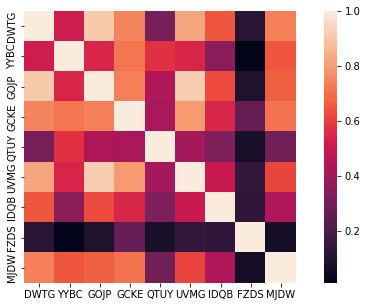

In [68]:
corr_mat = np.abs(X_train.corr())
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_mat,square = True, ax = ax)

In [69]:
period = [3,5,10,21]
col = X_train.columns
for j in col:
  for i in period:
    X_train[f"pct_{j}_{i}"] = X_train[j].pct_change(i)
    X_train[f"pct_{j}_{i}"] = X_train[f"pct_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

    X_train[f"Volatility_{j}_{i}"] = np.log(X_train[j]).diff().rolling(i).std()
    X_train[f"Volatility_{j}_{i}"] = X_train[f"Volatility_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

In [70]:
X_train

,DWTG,YYBC,GOJP,GCKE,QTUY,UVMG,IDQB,FZDS,MJDW,pct_DWTG_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,99.661567,99.423036,100.320863,100.188276,101.484616,99.865500,101.086409,98.685564,99.142575,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-03,99.409426,97.360879,99.507999,98.932934,101.639198,98.671030,99.511884,101.265104,97.398578,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-04,99.110562,97.931147,98.945510,98.787116,100.689973,101.503570,100.059747,102.907880,98.346670,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-05,98.722860,97.265252,100.381085,98.788299,99.385565,102.268960,99.180151,101.040579,100.417669,-0.009419,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-06,98.490010,97.552069,99.024389,99.889633,100.767928,103.185455,98.853801,101.298598,101.596601,-0.009249,...,0.050806,0.014908,0.043101,0.005949,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,240.982723,56.132685,35.041399,242.974425,164.449277,366.019465,72.452885,166.485526,205.637195,-0.024227,...,0.042414,0.011112,0.014482,0.006442,0.033619,0.005211,0.049111,0.009879,0.069979,0.010529
2022-12-20,241.853681,56.363396,36.062196,244.085363,165.776735,370.203239,72.934123,167.838902,205.536991,-0.012321,...,0.046254,0.011181,0.011538,0.007156,0.022872,0.005611,0.059004,0.008706,0.076274,0.010339
2022-12-21,249.873543,56.011898,36.329600,246.031651,162.518466,375.634517,73.751441,168.260879,208.878235,0.022995,...,0.061409,0.010709,0.028110,0.008664,0.030471,0.007615,0.073278,0.009209,0.094307,0.010649


In [71]:
X_train.drop(col, axis = 1, inplace = True)

In [72]:
X_train

,pct_DWTG_3,Volatility_DWTG_3,pct_DWTG_5,Volatility_DWTG_5,pct_DWTG_10,Volatility_DWTG_10,pct_DWTG_21,Volatility_DWTG_21,pct_YYBC_3,Volatility_YYBC_3,...,pct_FZDS_21,Volatility_FZDS_21,pct_MJDW_3,Volatility_MJDW_3,pct_MJDW_5,Volatility_MJDW_5,pct_MJDW_10,Volatility_MJDW_10,pct_MJDW_21,Volatility_MJDW_21
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-03,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-04,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-05,-0.009419,0.000704,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,-0.021703,0.013407,...,0.050806,0.014908,0.012861,0.019858,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
2017-01-06,-0.009249,0.000783,-0.002382,0.005577,-0.016404,0.006921,0.037246,0.008689,0.001964,0.006635,...,0.050806,0.014908,0.043101,0.005949,0.038113,0.014725,0.046513,0.016425,-0.009096,0.014923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-19,-0.024227,0.005501,-0.002964,0.011207,-0.046415,0.010947,-0.062716,0.012958,0.019727,0.012367,...,0.042414,0.011112,0.014482,0.006442,0.033619,0.005211,0.049111,0.009879,0.069979,0.010529
2022-12-20,-0.012321,0.008666,-0.012387,0.008866,-0.043382,0.011158,-0.049035,0.012908,0.024196,0.011386,...,0.046254,0.011181,0.011538,0.007156,0.022872,0.005611,0.059004,0.008706,0.076274,0.010339
2022-12-21,0.022995,0.023314,0.011773,0.018103,0.004820,0.015296,-0.022032,0.014953,-0.003128,0.005179,...,0.061409,0.010709,0.028110,0.008664,0.030471,0.007615,0.073278,0.009209,0.094307,0.010649


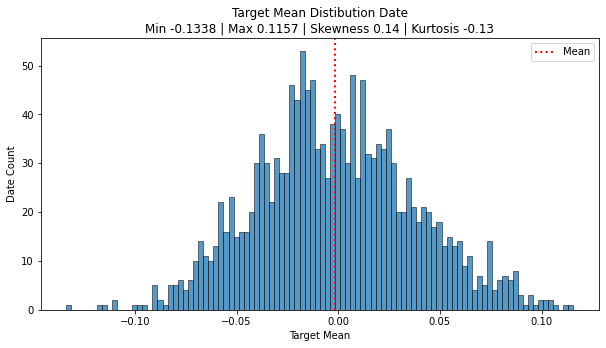

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=X_train["pct_IDQB_10"].values, bins=100,
             ax=ax)
ax.axvline(x=X_train["pct_IDQB_10"].mean(), color='red', linestyle='dotted', linewidth=2, 
           label='Mean')

ax.set_title("Target Mean Distibution Date\n"
             f"""Min {round(X_train["pct_IDQB_10"].min(), 4)} | """
             f"""Max {round(X_train["pct_IDQB_10"].max(), 4)} | """
             f"""Skewness {round(X_train["pct_IDQB_10"].skew(), 2)} | """
             f"""Kurtosis {round(X_train["pct_IDQB_10"].kurtosis(), 2)}""")

ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()


## Model selection

- K-Nearest Neighbour Regressor
- Decision tree
- Random Forest


In [74]:
mae_dict = {"KNN":[],"Decision_Tree":[],"Random_Forest":[]}

**K-Nearest Neighbour Regressor**





In [75]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
mae_ls = []

In [76]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    n_neighbors = 3
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors)
    knn_reg.fit(X_train_cross, y_train_cross)
    y_pred = knn_reg.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["KNN"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 11.21

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 10.9

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 20.99

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 13.9

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 9.05

Mean MAE 13.21
CPU tim

**Decision Tree** 



In [77]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
mae_ls = []

In [78]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(X_train_cross, y_train_cross)
    y_pred = tree_reg.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["Decision_Tree"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 14.97

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 10.36

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 18.15

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 13.16

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 10.99

Mean MAE 13.53
CPU 

**Random Forest**

In [79]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
feat_importance_forest = pd.DataFrame()
mae_ls = []

In [80]:
%%time
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X_train, y_train)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train_cross, y_train_cross = X_train.iloc[train_idx,:], y_train[train_idx]
    X_valid, y_val = X_train.iloc[val_idx,:], y_train[val_idx]
    
    print("Train Date range: {} to {}".format(X_train_cross.index.min(),X_train_cross.index.max()))
    print("Valid Date range: {} to {}".format(X_valid.index.min(),X_valid.index.max()))

    regr = RandomForestRegressor()
    regr.fit(X_train_cross, y_train_cross)
    y_pred = regr.predict(X_valid)

    mae = mean_absolute_error(y_val, y_pred)

    print(f"\nMAE: {round(mae,2)}")
    mae_ls.append(mae)


print(f"\nMean MAE {round(sum(mae_ls)/len(mae_ls),2)}")
mae_dict["Random_Forest"].append(round(sum(mae_ls)/len(mae_ls),2))


========================== Fold 1 ==========================
Train Date range: 2017-01-02 00:00:00 to 2017-12-15 00:00:00
Valid Date range: 2018-01-01 00:00:00 to 2018-12-28 00:00:00

MAE: 7.88

========================== Fold 2 ==========================
Train Date range: 2017-01-02 00:00:00 to 2018-12-14 00:00:00
Valid Date range: 2018-12-31 00:00:00 to 2019-12-27 00:00:00

MAE: 7.07

========================== Fold 3 ==========================
Train Date range: 2017-01-02 00:00:00 to 2019-12-13 00:00:00
Valid Date range: 2019-12-30 00:00:00 to 2020-12-25 00:00:00

MAE: 18.42

========================== Fold 4 ==========================
Train Date range: 2017-01-02 00:00:00 to 2020-12-11 00:00:00
Valid Date range: 2020-12-28 00:00:00 to 2021-12-24 00:00:00

MAE: 10.07

========================== Fold 5 ==========================
Train Date range: 2017-01-02 00:00:00 to 2021-12-10 00:00:00
Valid Date range: 2021-12-27 00:00:00 to 2022-12-23 00:00:00

MAE: 8.51

Mean MAE 10.39
CPU tim

**Selecting the best model**

In [81]:
print(mae_dict)

{'KNN': [13.21], 'Decision_Tree': [13.53], 'Random_Forest': [10.39]}


Since Random Forest model provides a better MAE, it will be used to build the final model

In [82]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
ts_fold = TimeSeriesSplit(n_splits=5,gap=10)
regr_final = RandomForestRegressor()

gsearch = GridSearchCV(estimator=regr_final, cv=ts_fold,
                       scoring = 'neg_mean_absolute_percentage_error',
                      param_grid=random_grid)
gsearch.fit(X_train, y_train)
results = gsearch.cv_results_

In [ ]:
results

## Final Model

In [ ]:
final_model = gsearch.best_estimator_
final_model.fit(X_train, y_train)

In [ ]:
period = [3,5,10,21]
col = X_test.columns
for j in col:
  for i in period:
    X_test[f"pct_{j}_{i}"] = X_test[j].pct_change(i)
    X_test[f"pct_{j}_{i}"] = X_test[f"pct_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

    X_test[f"Volatility_{j}_{i}"] = np.log(X_test[j]).diff().rolling(i).std()
    X_test[f"Volatility_{j}_{i}"] = X_test[f"Volatility_{j}_{i}"].interpolate(method='linear',limit_direction='backward')

In [ ]:
y_final_pred = regr.predict(X_test)
final_mae = mean_absolute_error(y_test, y_final_pred)


In [ ]:
final_mae